## Amazon Fine Food Review - Truncated SVD

### 1. Objective

                To Cluster the same type of Data points.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
import sqlite3
warnings.filterwarnings("ignore")

### 2. Data Cleaning 

In [2]:
#connecting database

con=sqlite3.connect("database.sqlite")

# Read data from database

raw_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3""",con)

# Removal of Duplicates

pre_data=raw_data.drop_duplicates(['UserId','ProfileName','Time','Text'],keep="first")

# Removal of Unconditioning data (denominator>numerator)

pre_data=pre_data[pre_data.HelpfulnessNumerator<=pre_data.HelpfulnessDenominator]


# Finding NaN values in dataframe

# Reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html

# Findind NaN values

if pre_data.isnull().values.any() == False:
    print("There is No NaN values in the DataFrame")
else:
    print(" There is NaN values present in the DataFrame")

There is No NaN values in the DataFrame


In [3]:
# sort data based on Time 

filter_data=pre_data.sort_values(by=["Time"],axis=0)

# Class Label changing
# positive class label = 1
# negative class label = 0
a=[]
for i in filter_data["Score"]:
    if i > 3:
        a.append(1)
    else:
        a.append(0)
filter_data["Score"]=a

In [4]:
filter_data.shape

(364171, 10)

In [5]:
filter_data["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

### 3. Text Preprocessing

* We took the Text column for the further review idendification task, because text is the most important feature compared to other features. 

In [6]:
# References
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
# https://stackoverflow.com/a/40823105/4084039
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
# https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number/18082370#18082370
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547#5843547
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://gist.github.com/sebleier/554280
# stemming tutorial: https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
# Lemmatisation tutorial: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
# NLTK Stemming package list: https://www.nltk.org/api/nltk.stem.html

from nltk.stem.snowball import EnglishStemmer
import re
from tqdm import tqdm
stemmer=EnglishStemmer()

In [7]:
raw_text_data=filter_data["Text"].values

In [8]:
# Stopwords

stopwords= set(['since','br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# expanding contractions

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
preprocessed_text_data=[]
for i in tqdm(raw_text_data):
# removing of HTML tags
    a=re.sub("<.*?>"," ",i)
# removing url
    b=re.sub(r"http\S+"," ",a)
# expanding contractions
    c=decontracted(b)
# removing alpha_numeric
    d=re.sub("\S*\d\S*", " ",c)
# removing Special characters
    e=re.sub('[^A-Za-z0-9]+', ' ',d)
# removing stopwords
    k=[]
    for w in e.split():
        if w.lower() not in stopwords:
            s=(stemmer.stem(w.lower())).encode('utf8')
            k.append(s)
    preprocessed_text_data.append(b' '.join(k).decode())

100%|██████████| 364171/364171 [06:59<00:00, 867.77it/s] 


In [10]:
filter_data["Text"]=preprocessed_text_data

In [11]:
filter_data.shape

(364171, 10)

### 4. Featurization:

#### 4.1 Data

In [12]:
# we took the sample data size as 100k 

final_data=filter_data[:100000]
final_data.shape

(100000, 10)

In [13]:
X=final_data.Text

#### 4.2 TFIDF

In [14]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
tfidf_model=TfidfVectorizer(min_df=5,max_features=2000)

# TFIDF on data 

tfidf_train_vec1=tfidf_model.fit_transform(X)

In [16]:
# the number of words in TFDIF or Vector size

print("The size of TFIDF vectorizer")
print(tfidf_train_vec1.get_shape())

The size of TFIDF vectorizer
(100000, 2000)


### 5. Co - Occurance Matrix

In [17]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [18]:
# To get the top 2000 features from the Tfidf Vectorizer using idf_score values

top_features=tfidf_model.get_feature_names()

In [20]:
# References 
# https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285
# https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.fill_diagonal.html
# https://www.geeksforgeeks.org/enumerate-in-python/
# https://stackoverflow.com/questions/41661801/python-calculate-the-co-occurrence-matrix/41663359
# https://github.com/PushpendraSinghChauhan/Amazon-Fine-Food-Reviews/blob/master/Computing%20Word%20Vectors%20using%20TruncatedSVD.ipynb
# https://riptutorial.com/python/example/1313/avoiding-keyerror-exceptions

In [21]:
# To store all the words in the sentences to the list

word_corpus = dict()
word_list=[]
index = 0

for i in tqdm(preprocessed_text_data[0:100000]):
    for words in i.split():
        word_list.append(words)
        word_corpus.setdefault(words,[])
        word_corpus[words].append(index)
        index += 1

100%|██████████| 100000/100000 [00:04<00:00, 21062.26it/s]


In [22]:
# Co-occurance matrix

window = 5

co_occurance_matrix = []
        
for i in tqdm(top_features):
           
    matrix_temp = []
    
    for j in top_features:
        
        if( i != j):
            
            word_occurance = 0
            
            try:
                
                word_indices = word_corpus[i]
                
            except KeyError:
                
                word_indices=[]
        
            
            for k in word_indices:
                
                if k<(window-1):
                    
                    # checking forward occurance
            
                    if j in word_list[k:k+window]:
                    
                        word_occurance +=1
                        
                elif (k>=(window-1)) and (k<=(len(word_list)-window)):
                    
                    # checking forward and backward occurance
                
                    if (j in word_list[k-(window-1):k+1]) and (j in word_list[k:k+window]):
                        
                        word_occurance +=2
                        
                    elif (j in word_list[k-(window-1):k+1]) or (j in word_list[k:k+window]):
                        
                        word_occurance +=1
                else :
                    
                    # checking forward occurance
                    
                    if (j in word_list[k-(window-1):k+1]):
                        
                        word_occurance +=1
                            
            matrix_temp.append(word_occurance)
            
        else:
                
            matrix_temp.append(0)  
                    
    co_occurance_matrix.append(matrix_temp)

100%|██████████| 2000/2000 [5:00:37<00:00,  2.32s/it]      


In [23]:
co_occurance_matrix=np.array(co_occurance_matrix)

In [24]:
co_occurance_matrix.shape

(2000, 2000)

### 6.Truncated SVD

In [25]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

from sklearn.decomposition import TruncatedSVD

In [26]:
model_SVD=TruncatedSVD(n_components=1000)
svd_matrix1=model_SVD.fit_transform(co_occurance_matrix)

In [27]:
variance_exp=model_SVD.explained_variance_ratio_

In [28]:
var_pdf=variance_exp/np.sum(variance_exp)

In [29]:
var_cum=np.cumsum(var_pdf)

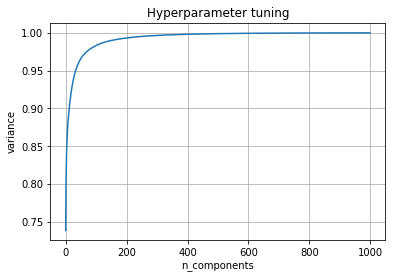

In [30]:
# plotting variance vs n_components
plt.close()
plt.plot(var_cum)
plt.xlabel("n_components")
plt.ylabel("variance")
plt.grid()
plt.title("Hyperparameter tuning")
plt.show()

##### Observation:

* By this cumulative variance plot we conclude 100 components is enough, Because 100 components explained almost 100 percentage variance. So n_components=100

In [31]:
# Apply best Hyperparameter

model_SVD=TruncatedSVD(n_components=100)
svd_matrix=model_SVD.fit_transform(co_occurance_matrix)

In [32]:
svd_matrix.shape

(2000, 100)

##### Observation:

* Each of the svd_matrix row ($Ri$) represents a <b>word_vectors</b> with the dimension of 100.

### 7. Dimensionality reduction (d to d' space)

In [33]:
a=tfidf_train_vec1.toarray()

In [34]:
b=svd_matrix

In [35]:
a.shape

(100000, 2000)

In [36]:
b.shape

(2000, 100)

In [37]:
tfidf_vector=np.matmul(a,b)

In [38]:
print("tfidf vector before dimensionality reduction")
print("="*100)
print(tfidf_train_vec1.shape)
print("tfidf vector After dimensionality reduction")
print("="*100)
print(tfidf_vector.shape)

tfidf vector before dimensionality reduction
(100000, 2000)
tfidf vector After dimensionality reduction
(100000, 100)


### 8.K-Means Clustering (after d to d')

In [39]:
# References 
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

from sklearn.cluster import KMeans

In [40]:

k = [2,3,4,5,6,8,10]

inertias=[]

for i in tqdm(k):
    
    model = KMeans(n_clusters=i,n_jobs=-1)
    model.fit(tfidf_vector)
    sum_sq_values = model.inertia_
    inertias.append(sum_sq_values)

100%|██████████| 7/7 [01:30<00:00, 17.30s/it]


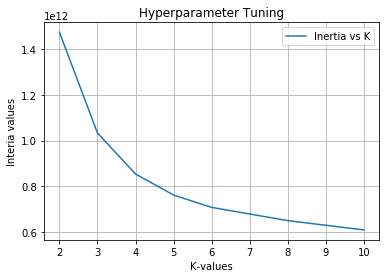

In [41]:
# plotting the k vs inertia 

plt.close()
plt.plot(k,inertias,label="Inertia vs K")
plt.grid()
plt.title("Hyperparameter Tuning")
plt.xlabel("K-values")
plt.ylabel("Interia values")
plt.legend()
plt.show()

##### Observation:

* By using the elbow method the best k (number of clusters) is 5

In [42]:
# Applying Best Hyperparameter

model= KMeans(n_clusters=5,n_jobs=-1)
model.fit(tfidf_vector)
labels=model.labels_

In [43]:
# Data points seperation as per the clusters

number_points = labels.shape[0]
print("Number of Datapoints")
print(number_points)

Number of Datapoints
100000


In [44]:
# Datapoints divided by clusters as per the label name

cluster_1=[]
cluster_2=[]
cluster_3=[]
cluster_4=[]
cluster_5=[]

for i in range(0,number_points):
    
    if labels[i] == 0:
        cluster_1.append(i)
    if labels[i] == 1:
        cluster_2.append(i)
    if labels[i] == 2:
        cluster_3.append(i)
    if labels[i] == 3:
        cluster_4.append(i)
    if labels[i] == 4:
        cluster_5.append(i)

In [45]:
# References
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

In [46]:
# The number of datapoints in each cluster

a=PrettyTable()

a.field_names = ["Cluster", "Number of Data Points"]

print(" The number of datapoints in each cluster")
print("="*120)

a.add_row([1,str(len(cluster_1))])
a.add_row([2,str(len(cluster_2))])
a.add_row([3,str(len(cluster_3))])
a.add_row([4,str(len(cluster_4))])
a.add_row([5,str(len(cluster_5))])
print(a)

 The number of datapoints in each cluster
+---------+-----------------------+
| Cluster | Number of Data Points |
+---------+-----------------------+
|    1    |          7833         |
|    2    |         28006         |
|    3    |         16592         |
|    4    |         19444         |
|    5    |         28125         |
+---------+-----------------------+


##### Wordcloud for each cluster:

###### Cluster 1

* Getting the sample reviews in Cluster 1

In [47]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(7833,size=3)

In [48]:
rand_num = list(rand_num)

In [49]:
rand_num

[3375, 2810, 6870]

In [50]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_1[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [51]:
string_1 = " ".join(word_cloud)

In [52]:
string_1

'sampl watermelon strawberri black cherri flavor curious flavor would tast love watermelon not usual like watermelon favor drink quit pleas sweet light not heavi syrupi tast not overwhelm right advertis carbon make go great meal like flavor tri no aftertast real sugar disappoint product tini oz not fan even amazon low price drink expens healthi conscious someth look real sugar no caffein no artifici stuff ingredi simpl not think go lose weight stuff calori per tini littl bit fewer serv size mountain dew juic probabl littl healthier product mani holiday recip becam unavail area similar product thing chocol along recip toffe bit piec sever groceri store area carri year past thought product no longer made much delight amazon not carri reason price one tip might add product come box freez perfect put extra ziploc bag pull bag freezer need product get rancid tast otherwis not use time manner frozen remain unchang not affect qualiti slightest let start say love genmaicha drink close cup day 

In [83]:
from wordcloud import WordCloud

In [84]:
wordcloud_1 = WordCloud(width=720, height=720, max_words=50).generate(string_1)

###### Cluster 2

* Getting the sample reviews in Cluster 2

In [54]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(28006,size=3)

In [55]:
rand_num = list(rand_num)

In [56]:
rand_num

[17053, 25294, 8889]

In [57]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_2[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [58]:
string_2 = " ".join(word_cloud)

In [59]:
string_2

'love easi handl easi take trip keep better int small packag instead buy larger box unless eat quick not huge cracker eater work great us easi dip could no longer find product local happili order amazon great ad coffe cafe mocha realli delcious strawberri top chocol ice cream banana made qualiti ingredi without lot preserv would order price cheap order process fast took day get product plus free ship felt convin buy product amazon'

In [85]:
wordcloud_2 = WordCloud(width=720, height=720, max_words=50).generate(string_2)

###### Cluster 3

* Getting the sample reviews in Cluster 3

In [60]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(16592,size=3)

In [61]:
rand_num = list(rand_num)

In [62]:
rand_num

[12400, 12587, 13273]

In [63]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_3[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [64]:
string_3 = " ".join(word_cloud)

In [65]:
string_3

'kitchen india curri past becom stapl item pantri home allow fast meal weekday slight elabor meal weekend thin crisp fragrant cooki delici tasti excel glass cold almond milk hot herbal tea choic like ginger snap love lar ginger snap alway love cooki delight find sourc reliabl'

In [86]:
wordcloud_3 = WordCloud(width=720, height=720, max_words=50).generate(string_3)

###### Cluster 4

* Getting the sample reviews in Cluster 4

In [66]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(19444,size=3)

In [67]:
rand_num = list(rand_num)

In [68]:
rand_num

[628, 13091, 15368]

In [70]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_4[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [71]:
string_4 = " ".join(word_cloud)

In [72]:
string_4

'ador light version madhava agav versatil use hot cold drink sweeten without sort aftertast mix easili perfect compliment tea coffe especi yummi vanilla rooibo also use place sugar various recip especi dress prefer honey not crystal low gycem index eat honey like inject sugar straight bloodstream agav high fructos slowli releas bloodstream not sugar crash use amber varieti place mapl syrup use light version type sweeten one sweet tooth anoth agav satisfi make tea love gum ca not find anywher store littl pricey buy bulk not find store regular not fine bisqu find punch littl wine dice fresh lobster meat order case alreadi use two dinner parti guest impress thought made scratch realli like bold tast tradit type bisqu like brand would not hesit buy'

In [87]:
wordcloud_4 = WordCloud(width=720, height=720, max_words=50).generate(string_4)

###### Cluster 5

* Getting the sample reviews in Cluster 5

In [73]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randint.html


# randomly generated index values

rand_num = np.random.randint(28125,size=3)

In [74]:
rand_num = list(rand_num)

In [75]:
rand_num

[8417, 28122, 13850]

In [76]:
# Reviews in the cluster 1

index=[]
word_cloud=[]

for i in rand_num:
    
    index.append(cluster_5[i])
    
for i in index:
    
    word_cloud.append(X.values[i])

In [78]:
string_5 = " ".join(word_cloud)

In [79]:
string_5

'one delici gummi iv ever recommend get love reason price organ oatmeal bulk quantiti amazon com sell last long time addit qualiti consist enjoy soda tast reason natur bit sweet perhap certain less sweet soda serv size oz not work small sit meal folk sip soda day small size might virtu guy would well reduc volum'

In [88]:
wordcloud_5 = WordCloud(width=720, height=720, max_words=50).generate(string_5)

##### Plotting The Wordcloud 

* <b>Cluster 1<b> 

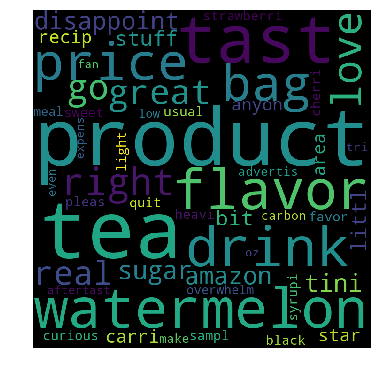

In [89]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_1) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about drinking flavour powder products.

* <b>Cluster 2<b>

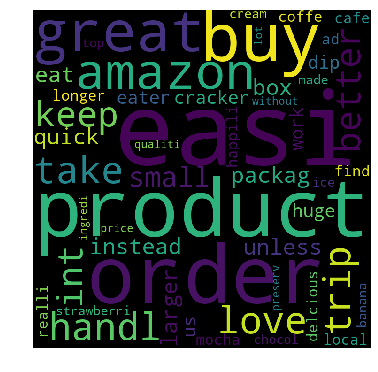

In [90]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

###### Observation:

* This cluster says about product quantity and quality

* <b>Cluster 3<b>

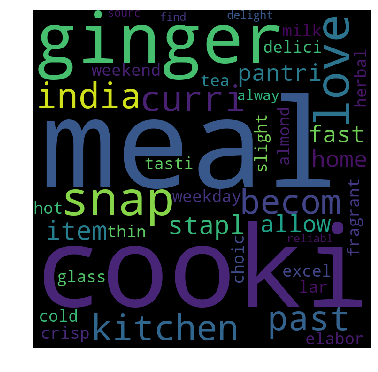

In [91]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_3) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about cooking products.

* <b>Cluster 4<b>

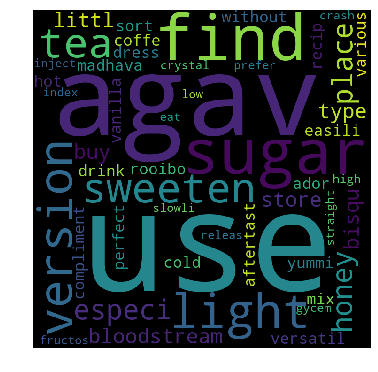

In [92]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_4) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about drink based products.

* <b>Cluster 5<b>

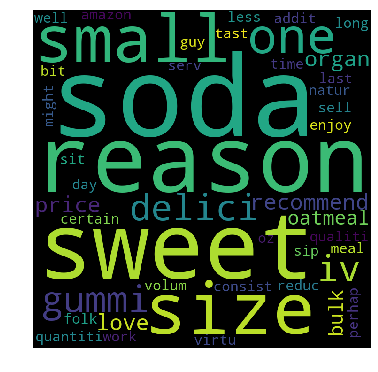

In [93]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(wordcloud_5) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

###### Observation:

* This cluster says about product quality and taste.

### 9.Word Vector similarity (Feature words similarity)

In [94]:
# References 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

from sklearn.metrics.pairwise import cosine_similarity

In [123]:
# fuction for word_vector similarity using cosine similarity

def similar_vectors(**para):
    
    similarity_matrix=cosine_similarity(para["matrix"])
    index=top_features.index(para["word"])
    similar_words=np.argsort(similarity_matrix[index,:])[::-1]
    similar_words=list(similar_words[0:10])
    list_words=[]
    for i in similar_words:
        list_words.append(top_features[i])
        
    return list_words

In [130]:
similar_words=similar_vectors(matrix=svd_matrix,word="sweet")

In [131]:
print("The similar words of word 'SWEET'")
print("="*100)
print(similar_words)

The similar words of word 'SWEET'
['sweet', 'heavi', 'bland', 'power', 'okay', 'salti', 'although', 'wateri', 'ok', 'sugari']


In [136]:
string_similar_words=" ".join(similar_words)

# Word cloud

similar_word_cloud=WordCloud(width=720, height=720, max_words=50).generate(string_similar_words)

##### similar words to word "SWEET"

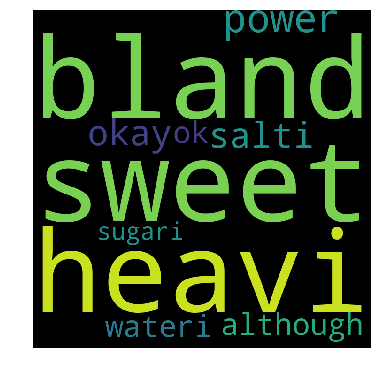

In [137]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(similar_word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [138]:
similar_words=similar_vectors(matrix=svd_matrix,word="tast")

In [140]:
print("The similar words of word 'taste'")
print("="*100)
print(similar_words)

The similar words of word 'taste'
['tast', 'sound', 'realli', 'feel', 'thing', 'flavor', 'seem', 'folk', 'look', 'man']


In [141]:
string_similar_words=" ".join(similar_words)

# Word cloud

similar_word_cloud=WordCloud(width=720, height=720, max_words=50).generate(string_similar_words)

##### similar words to word "TASTE"

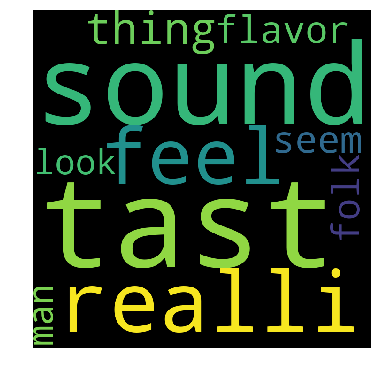

In [142]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(similar_word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [143]:
similar_words=similar_vectors(matrix=svd_matrix,word="tea")

In [144]:
print("The similar words of word 'tea'")
print("="*100)
print(similar_words)

The similar words of word 'tea'
['tea', 'beer', 'coffe', 'pink', 'bright', 'still', 'licoric', 'yeah', 'also', 'origin']


In [145]:
string_similar_words=" ".join(similar_words)

# Word cloud

similar_word_cloud=WordCloud(width=720, height=720, max_words=50).generate(string_similar_words)

##### similar words to word "TEA"

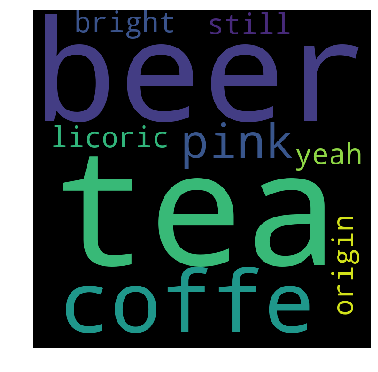

In [146]:
plt.close()
plt.figure(figsize = (5,5)) 
plt.imshow(similar_word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

### 10. Conclusion

##### Data Cleaning ,Preprocessing and splitting:

* In the Data Cleaning process, we clean the duplicate datapoints and unconditioning data points. After the data cleaning process we get 364171 data points and sort based on timestamp.
* Then select the Review Text Feature as a important feature, then do data preprocessing on all the data points.
* Then select top 100k sample data points for further process.

##### Featurization:

* Then apply the data points on TFIDF for converting text to vector.

##### Truncated SVD:

* The <b>co-occurance matrix</b> of the top 2000 words was calculated by using idf_score of the tfidf. 
* Using the co-occurance matrix the Truncated SVD was performed. 
* After performing truncated svd we got word_vectors for each word.
* After the Truncated SVD We reduce the dimensions of the tfidf vector from 100000 x 2000 to 100000 x 100 (d dimension to d' dimension).

##### K-means model:

* Then apply the dimension reduced tfidf vector on K - means model.Best number of clusters are find out by using elbow method.
* After the Dimensionality reduction the clusters performance(Interpretability) was good.

##### Wordcloud:

* After the k means, the Wordcloud were produced for each clusters.

##### Word_ vector Similarity:

* The word_vector similarity finded out by using cosine similarity.
* The top 10 similar words are displayed by using Wordcloud.